- ссылка на презентацию pdf https://drive.google.com/file/d/1SjlPkN2x4hzETIRrxyWBmUy5yB6LSUIJ/view?usp=sharing
- ссылка на дашборд https://public.tableau.com/app/profile/aleksandr4993/viz/Diplom_16268623041640/Sheet1?publish=yes

# Цель исследования

Мы работаем в отделе анализа данных ИМ "Пока все ещё тут". Перед нами стоит задача - сегментировать покупателей по профилю потребления. После этого мы сможем дать рекомендации продакт-менеджеру: как грамотно предлагать покупателям товары.

Будем следовать следующему плану:

- [ознакомимся с данными, изучим общую информацию](#1)
- [предобработаем данные (заполним пропуски, определимся с дубликатами и типами данных и тд.)](#2)
- [проведем иссследовательский анализ (зависимости, выбросы, аномалии и тд)](#3)
- [разобьем товары на категории](#4)
- [сегментируем покупателей на основе истории их покупок](#5)
- [проверим статистические гиипотезы](#6)
- [сделаем вывод и дадим рекомендации коллегам](#7)
- создадим дашборд в Tableau

## Знакомство с данными
<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from datetime import datetime
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from scipy import stats as st

In [2]:
df = pd.read_csv('C:\\Users\\Александр\Datasets/ecommerce_dataset.csv')

In [3]:
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


В итоге имеем небольшой датасет; займемся его предобработкой

## Предобработка данных
<a id='2'></a>

Как видим, столбец даты у нас принимает значения целого числа. Приведем к его к нужному формату  и также добавим столбец месяца

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')  
df['month_per'] = df['date'].dt.to_period('M')
df['month_dt'] = df['date'].dt.month

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 8 columns):
date           6737 non-null datetime64[ns]
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
month_per      6737 non-null period[M]
month_dt       6737 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(2), period[M](1)
memory usage: 421.2+ KB


Проверим столбец даты на адекватность: нет ли там странных значений?

In [7]:
df['date'].min()

Timestamp('2018-10-01 00:00:00')

In [8]:
df['date'].max()

Timestamp('2019-10-31 16:00:00')

Пропусков значений не наблюдаем (судя по info) - это хорошо.

Что касается дубликатов: нужно посмотреть, нет ли полных совпадений по строкам. По здравом размышлении значения в отдельных столбцах могут и будут повторяться (в один день несколько заказов, один и тот же товар заказан в разные дни и тд)

In [9]:
df.duplicated().sum()

0

А нет ли у нас скрытых дубликатов? Можно проверить "глазами", исследовав несколько заказов

In [10]:
df.query('order_id == 13547')

,date,customer_id,order_id,product,quantity,price,month_per,month_dt
102,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-10,10
103,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-10,10
104,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0,2018-10,10
376,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-10,10
377,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-10,10
378,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0,2018-10,10
509,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-10,10
510,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-10,10
511,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0,2018-10,10
588,2018-11-02 14:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-11,11


Думается, что дубли в похожих случаях появляются из-за смены статуса заказа. Поэтому удалим те строки, в которых имеют место повторения сразу по трем столбцам

In [11]:
df = df.drop_duplicates(subset=['order_id', 'product', 'price'])

In [12]:
# проверим
df.query('order_id == 13547')

,date,customer_id,order_id,product,quantity,price,month_per,month_dt
102,2018-10-05,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-10,10
103,2018-10-05,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-10,10
104,2018-10-05,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0,2018-10,10


С дубликатами покончено, идем дальше

## Исследовательский анализ данных
<a id='3'></a>

In [13]:
df.head()

,date,customer_id,order_id,product,quantity,price,month_per,month_dt
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,10
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,10
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,10
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,10
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,10


Добавим столбец, в котором посчитаем: сколько денег было заплачено за конкретный товар с учетом его количества

In [14]:
df['total_price'] = df['price'] * df['quantity']

In [15]:
df.head()

,date,customer_id,order_id,product,quantity,price,month_per,month_dt,total_price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,10,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,10,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,10,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,10,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,10,112.0


Создадим фрейм, где посчитаем общую стоимость каждого заказа

In [16]:
df_total = df.groupby('order_id')['total_price'].sum().reset_index()
df_total.head()

,order_id,total_price
0,12624,375.0
1,13547,684.0
2,14480,359.0
3,14481,600.0
4,14482,376.0


Теперь объединим две таблицы. Также переименуем столбцы для понимания различий: у нас появится стоимость заказа (order_price) и стоимость конкретного продукта (product_price)

In [17]:
df = df.merge(df_total, on='order_id', how='left')
df.head()

,date,customer_id,order_id,product,quantity,price,month_per,month_dt,total_price_x,total_price_y
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,10,142.0,1037.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,10,194.0,1037.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,10,112.0,1037.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,10,179.0,1037.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,10,112.0,1037.0


In [18]:
df = df.rename(columns={'total_price_y': 'order_price', 'total_price_x': 'product_price'})
df.head()

,date,customer_id,order_id,product,quantity,price,month_per,month_dt,product_price,order_price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,10,142.0,1037.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,10,194.0,1037.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,10,112.0,1037.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,10,179.0,1037.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,10,112.0,1037.0


Приступим к анализу

In [19]:
df.describe()

,order_id,quantity,price,month_dt,product_price,order_price
count,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000,4820.000000
mean,48155.651452,2.810996,516.096680,6.517842,851.744606,1676.178423
std,27353.140457,17.670069,946.944532,3.298130,9860.659143,10023.950748
min,12624.000000,1.000000,9.000000,1.000000,9.000000,14.000000
25%,14771.000000,1.000000,90.000000,4.000000,120.000000,470.000000
50%,68855.000000,1.000000,150.000000,6.000000,192.500000,974.000000
75%,70815.000000,1.000000,488.000000,10.000000,734.000000,1804.000000
max,73164.000000,1000.000000,14917.000000,12.000000,675000.000000,675000.000000


Начнем со столбца заказов (order_id). Есть ощущение, что мы используем в работе не сплошной массив заказов, а несколько склееных между собой выборок: об этом говорит резкое увеличение порядкового номера заказа еще до середины списка. Нужно уточнить у заказчика, с чем это связано и располагам ли мы всей среднестатистиечской информацией. Или имеем дело с выборками, которые отличаются от средних. То есть, по факту, нам нужно понимать: имеем ли мы право делать выводы на основании данного пула заказов

В столбце стоимости заказов (order_price) также есть интересная деталь: среднее значение сильно отличается от медианного. Посмотрим, что за выбросы у нас присутствуют.

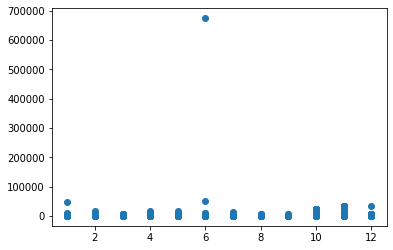

In [20]:
plt.scatter(data=df, x='month_dt', y='order_price')
plt.show()

Исключим явный выброс

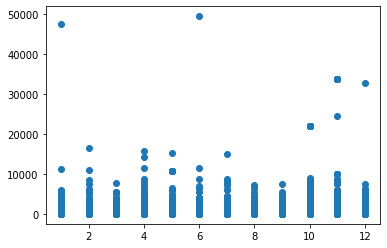

In [21]:
plt.scatter(data=df.query('order_price < 600000'), x='month_dt', y='order_price')
plt.show()

Возьмем за гипотезу, что аномальная граница стоимости заказа приходится на сумму в 15000, тогда посмотрим на совокупную выручку магазина в разных срезах

In [22]:
#срез отбросит только 1 процент, это приемлимо для нас
len(df.query('order_price < 15000')) / len(df)

0.9927385892116183

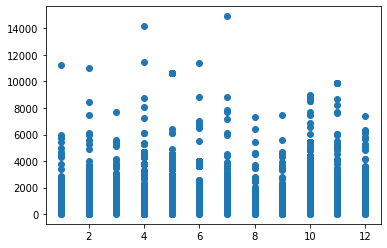

In [23]:
plt.scatter(data=df.query('order_price < 15000'), x='month_dt', y='order_price')
plt.show()

In [24]:
df.groupby('month_per')['product_price'].sum().reset_index()

,month_per,product_price
0,2018-10,351536.0
1,2018-11,359348.0
2,2018-12,354038.0
3,2019-01,230934.0
4,2019-02,306442.0
5,2019-03,251561.0
6,2019-04,317602.0
7,2019-05,236031.0
8,2019-06,901515.0
9,2019-07,234932.0


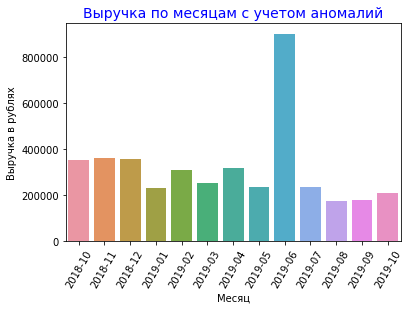

In [25]:
# общее распределение выручки по месяцам
sns.barplot(data=df.groupby('month_per')['product_price'].sum().reset_index(), x='month_per', y='product_price')
plt.xticks(rotation=60)
plt.title('Выручка по месяцам с учетом аномалий', color = 'blue', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Выручка в рублях')
plt.show()

Есть немало выбросов (стоимость заказа более 15000) причем многие из них приходятся на июнь 2019), на которые взглянем более пристально

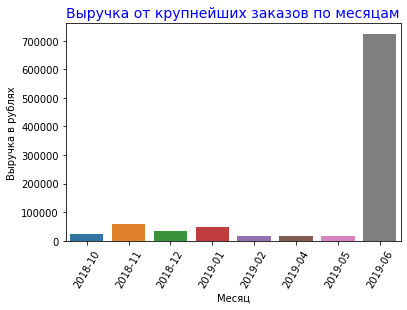

In [26]:
# распределение выручки при стоимости заказа свыше 15000
sns.barplot(data=df.query('order_price > 15000').groupby('month_per')['product_price'].sum().reset_index(), x='month_per', y='product_price')
plt.xticks(rotation=60)
plt.title('Выручка от крупнейших заказов по месяцам', color = 'blue', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Выручка в рублях')
plt.show()

Кто же эти люди, которые совершают крупные заказы в разные месяца? Вычислим их

In [27]:
df.query('order_price > 15000').groupby('customer_id').agg({'product_price': 'sum'}).reset_index().sort_values(by='product_price', ascending=False)

,customer_id,product_price
2,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,675000.0
0,146cd9bf-a95c-4afb-915b-5f6684b17444,49432.0
4,58a4c3cc-504f-43ea-a74a-bae19e665552,47385.0
7,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,33680.0
6,6987e6d6-a63a-4ce2-a2d0-f424092d235e,32718.0
1,1b2764ad-9151-4051-a46a-9b01b62e6335,24370.0
9,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,22056.0
8,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,16536.0
3,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,15680.0
5,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,15300.0


In [28]:
# создадим список заказов с крупными суммами
list = df.query('order_price > 15000').groupby('customer_id').agg({'product_price': 'sum', 'order_id': 'unique'}).reset_index()['order_id']

In [29]:
list

0    [71668]
1    [68878]
2    [71743]
3    [71206]
4    [69830]
5    [71478]
6    [69504]
7    [69156]
8    [70080]
9    [68760]
Name: order_id, dtype: object

In [30]:
# выделим из общего датафрейма вышеупомянутые заказы
df.query('order_id.isin(list)')

,date,customer_id,order_id,product,quantity,price,month_per,month_dt,product_price,order_price
389,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка деревянная с расширенными плечиками и ...,8,262.0,2018-10,10,2096.0,22056.0
390,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка для блузок 41 см черный Attribute AHM791,9,50.0,2018-10,10,450.0,22056.0
391,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка с закругленными плечиками без переклад...,7,106.0,2018-10,10,742.0,22056.0
392,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Гладильная доска Sarayli Tamara 125x42 см,1,3074.0,2018-10,10,3074.0,22056.0
393,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик влаговпитывающий ребристый 50х80 см Ста...,1,299.0,2018-10,10,299.0,22056.0
394,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик влаговпитывающий ребристый 60х90 см Ста...,1,412.0,2018-10,10,412.0,22056.0
395,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик придверный грязеулавливающий резиновый ...,1,284.0,2018-10,10,284.0,22056.0
396,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Короб стеллажный с крышкой большой, 30*40*25 с...",1,674.0,2018-10,10,674.0,22056.0
397,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Короб стеллажный с крышкой малый, 28*30*16 см,...",3,524.0,2018-10,10,1572.0,22056.0
398,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коробка для хранения на молнии из синтетическо...,1,749.0,2018-10,10,749.0,22056.0


In [31]:
df.query('order_id.isin(list)').groupby('order_id').agg({'order_price': 'first'})

,order_price
order_id,
68760,22056.0
68878,24370.0
69156,33680.0
69504,32718.0
69830,47385.0
70080,16536.0
71206,15680.0
71478,15300.0
71668,49432.0


Кто-то очень хорошо закупается) Видимо, это перекупы-предприниматели, которые закупаются большими объемами, а потом продают товары в розницу. Или, например, выигравший госзаказ бизнесмен с разовой закупкой. Запрещать мы этого им не будем. А вот коллегам обязательно дадим знать, что провели с ними переговоры по предоставлению индивидуальных условий при совершении регулярных подобных заказов. В любом случае, данные строки нам стоит исключить из фрейма, так как они являются очевидными выбросами

In [32]:
df = df.query('order_price < 15000')

Понятно, что в крупных чеках могли быть и заказы с большим количеством одного и того е товара. Но, быть может, выбросы по количеству товаров в заказе сохранились и в очищенном фрейме? 

In [33]:
df.describe()

,order_id,quantity,price,month_dt,product_price,order_price
count,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000
mean,48001.453918,2.437827,512.921630,6.498015,663.166562,1366.249321
std,27393.198843,7.967190,942.752606,3.294753,1149.180151,1376.761899
min,12624.000000,1.000000,9.000000,1.000000,9.000000,14.000000
25%,14770.000000,1.000000,90.000000,4.000000,120.000000,466.000000
50%,68857.000000,1.000000,150.000000,6.000000,190.000000,974.000000
75%,70828.000000,1.000000,488.000000,10.000000,734.000000,1798.000000
max,73164.000000,200.000000,14917.000000,12.000000,14917.000000,14917.000000


(0, 300)

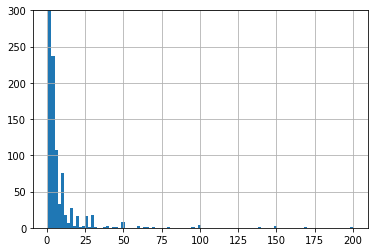

In [34]:
df['quantity'].hist(bins=100)
plt.ylim((0, 300))

In [35]:
df.query('quantity > 30')

,date,customer_id,order_id,product,quantity,price,month_per,month_dt,product_price,order_price
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,Крючок одежный 2-х рожковый серый металлик с п...,96,38.0,2018-10,10,3648.0,3648.0
138,2018-10-08 15:00:00,9151d307-654c-4239-a888-ada5ca45f0b2,68571,Набор вешалок для костюма 45см 4шт цвет: кремо...,37,202.0,2018-10,10,7474.0,7474.0
146,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,"Стяжка оконная с болтом СТ-55 цинк, 1108354",64,19.0,2018-10,10,1216.0,1216.0
197,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0,2018-10,10,2850.0,8550.0
198,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150,38.0,2018-10,10,5700.0,8550.0
219,2018-10-12 15:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68623,"Петля приварная гаражная d 14х90 мм с шаром, 1...",50,38.0,2018-10,10,1900.0,1900.0
256,2018-10-17 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,Щетка для посуды *Мила* SV3182 1807009,50,27.0,2018-10,10,1350.0,3550.0
257,2018-10-17 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68668,"Щетка-утюжок с ручкой Миди, Standart, York, G1126",50,44.0,2018-10,10,2200.0,3550.0
484,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,2018-11,11,8670.0,8670.0
502,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,2018-11,11,8260.0,8260.0


In [36]:
len(df.query('quantity > 30')) / len(df)

0.006896551724137931

Исключим из нашего фрейма еще 7% данных - выбросов по количеству товаров в одном заказе

In [37]:
df = df.query('quantity < 30')

Теперь обратимся к ОЧИЩЕННЫМ данным (сумма заказа меньше 15000 и количество товаров в заказе меньше 30)

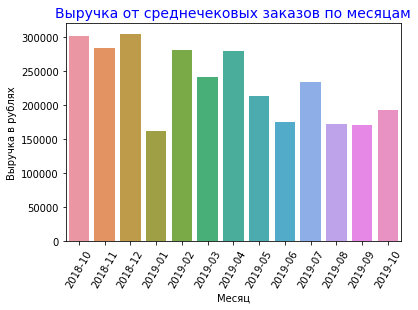

In [38]:
sns.barplot(data=df.groupby('month_per')['product_price'].sum().reset_index(), x='month_per', y='product_price')
plt.xticks(rotation=60)
plt.title('Выручка от среднечековых заказов по месяцам', color = 'blue', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Выручка в рублях')
plt.show()

Эта картина больше похоже на нормальную: мы очистили данные от выбросов и понимаем, сколько выручки сгенерировали за период

Теперь можем глянуть, какие товары у нас самые ходовые. Для этого будем использовать крайний срез данных - выделим в отдельный фрейм с заказами стоимостью менее 15000

In [39]:
df['product'].value_counts(ascending=False).head(20)

Пеларгония розебудная Red Pandora укорененный черенок                                                      65
Пеларгония розебудная Prins Nikolai укорененный черенок                                                    55
Пеларгония зональная диам. 12 см сиреневый полумахровый                                                    52
Сумка-тележка 2-х колесная Gimi Argo синяя                                                                 47
Пеларгония розебудная Mary укорененный черенок                                                             39
Пеларгония розебудная Queen Ingrid укорененный черенок                                                     30
Пеларгония розебудная Margaretha укорененный черенок                                                       29
Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок                                         24
Пеларгония зональная диам. 12 см коралловая полумахровая                                                   24
Пеларгония

Есть ощущение, что среди наших покупателей очень много дачников: они закупают как рассаду, так и готовые цветы. Это мы проверим в следующих разделах

А какие из товаров приносят больще всего выручки?

In [40]:
df.head()

,date,customer_id,order_id,product,quantity,price,month_per,month_dt,product_price,order_price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,10,142.0,1037.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,10,194.0,1037.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,10,112.0,1037.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,10,179.0,1037.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,10,112.0,1037.0


In [41]:
df.groupby('product').agg({'product_price': 'sum'}).reset_index().sort_values(by='product_price', ascending=False).head(10)

,product,product_price
1583,Сумка-тележка 2-х колесная Gimi Argo синяя,50405.0
1609,Сумка-тележка хозяйственная Andersen Scala Sho...,28045.0
131,"Веник сорго с деревянной ручкой с 4-мя швами, ...",20010.0
1594,Сумка-тележка 3-х колесная Gimi Tris Floral синяя,18893.0
1614,Сумка-тележка хозяйственная Andersen Treppenst...,18560.0
1612,Сумка-тележка хозяйственная Andersen Scala Sho...,18296.0
1592,Сумка-тележка 2-х колесная складная Gimi Flexi...,18139.0
274,Гладильная доска НИКА BLUES 124х46 см 5757,17786.0
522,Коврик придверный Attribute NATURE кокосовый 6...,16888.0
1666,Сушилка Meliconi Stendy Junior,16782.0


Будем это иметь ввиду на будущее

## Категоризация товаров
<a id='4'></a>

Есть подозрение, что нам очень не хватает категоризации товаров. Ей и займемся. Определим разные товары по категориям.

Напишем функцию, которая по части названия будет относить конкретный товар к определнному виду.

In [42]:
def find_cat(product):
    if 'умка' in product:
        return 'сумки'
    elif 'ешал' in product or 'одежд' in product or 'рищепк' in product or 'рючок' in product:
        return 'одежда'
    elif 'ассада' in product or  'еларгония' in product or 'растение' in product or 'Зумула' in product or 'Бакопа' in product or 'Петуния' in product or 'Калибрахоа' in product or 'Эвкалипт' in product or 'Каланхоэ' in product or 'Фиалка' in product or 'Осина' in product or 'ербена' in product or 'патифил' in product or 'ашпо' in product or 'd-' in product or 'цветок' in product or 'помидор' in product:
        return 'растения'
    elif 'ушилка' in product or 'ладильн' in product or 'ешал' in product or 'ехол' in product or 'едро' in product or 'ележка' in product or 'орыто' in product or 'тремянк' in product or 'естниц' in product or 'Полки' in product or 'Веник' in product or 'онтейнер' in product or 'уличная' in product or 'рючок' in product or 'пингалет' in product or 'щетка' in product or 'Щетка' in product or 'ермометр' in product or 'рючок' in product or 'оврик' in product or 'ружин' in product or 'скоба' in product or 'инструмен' in product:
        return 'быт'
    elif 'айник' in product or 'столов' in product or 'чайн' in product or 'обеден' in product or 'астрюля' in product or 'алатник' in product or 'людо' in product or 'анка' in product or 'ковород' in product or 'увшин' in product or 'овощей' in product or 'алфетка' in product or 'катерть' in product or 'мкость' in product or 'нож' in product or 'Нож' in product or 'посуд' in product or 'стакан' in product or 'ужер' in product or 'ружка' in product or 'арелка' in product or 'бокал' in product:
        return 'кухня'
    elif 'арниз' in product or 'ванной' in product or 'иденье' in product or 'Ёрш' in product or 'Таз' in product or 'антуз' in product or 'олотенц' in product or 'зубная' in product or 'ванны' in product:
        return 'ванная'
    return 'остальное'

Данную информацию добавим в отдельный столбец

In [43]:
df['cat'] = df['product'].apply(find_cat)
df.head(10)

,date,customer_id,order_id,product,quantity,price,month_per,month_dt,product_price,order_price,cat
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,10,142.0,1037.0,растения
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,10,194.0,1037.0,растения
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,10,112.0,1037.0,растения
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,10,179.0,1037.0,растения
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,10,112.0,1037.0,растения
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,2018-10,10,164.0,1037.0,растения
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,2018-10,10,134.0,1037.0,растения
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,2018-10,10,824.0,824.0,быт
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0,2018-10,10,269.0,269.0,ванная
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0,2018-10,10,674.0,674.0,быт


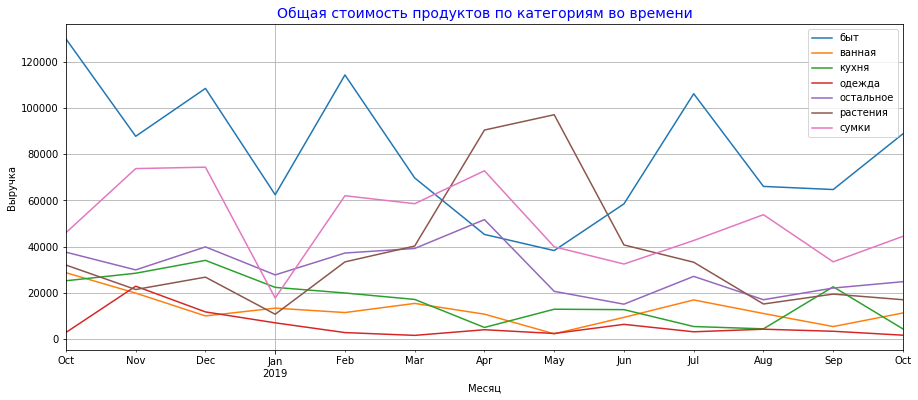

In [44]:
#построим график, отражающий тенеденции в продажах по месяцам
fig, ax = plt.subplots(figsize = (15,6))
df.pivot_table(index='month_per', columns='cat', values='product_price', aggfunc='sum').plot(ax=ax)
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.title('Общая стоимость продуктов по категориям во времени', color = 'blue', fontsize=14)
plt.grid(True)
ax.legend(loc='upper right')
plt.show()

Ничего сверхъестественного на графике не видим: есть вполне ожидаемый спад в январе (во всех сферах), есть сезонный рост закупок растений весной + предновогодний всплеск

Посмотрим, какие категории у нас самые продаваемые

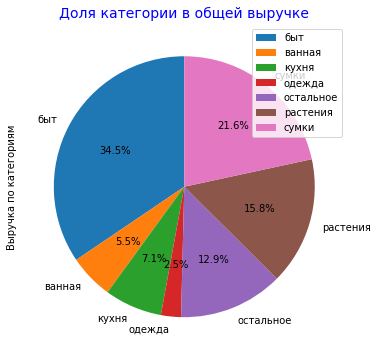

In [45]:
df.groupby('cat').agg({'product_price': 'sum'}).plot.pie(y='product_price', figsize=(6, 6), autopct='%1.1f%%', startangle=90)
plt.ylabel('Выручка по категориям')
plt.title('Доля категории в общей выручке', color = 'blue', fontsize=14)
plt.show()

## Сегментация покупателей
<a id='5'></a>

In [46]:
df.head()

,date,customer_id,order_id,product,quantity,price,month_per,month_dt,product_price,order_price,cat
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,10,142.0,1037.0,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,10,194.0,1037.0,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,10,112.0,1037.0,растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,10,179.0,1037.0,растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,10,112.0,1037.0,растения


Создадим вспомогательный фрейм; затем напишем функцию, которая будет принимать значение 1, если у покупателя всего 1 заказ, и 0 - если заказов больше одного. Далее объединим вспомогательный фрейм с основным.

In [47]:
# ВСПОМОГАТЕЛЬНЫЙ ФРЕЙМ
ddd = (df.groupby(['customer_id'])
       .agg({'order_id': 'nunique'})
       .reset_index()
       #.sort_values(by='order_id', ascending=False)
      )
ddd

,customer_id,order_id
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1
1,001cee7f-0b29-4716-b202-0042213ab038,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1
...,...,...
2370,ff601403-b094-4b86-9ac6-264d725b9277,1
2371,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1
2372,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1
2373,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1


In [48]:
def repeat(order_id):
    if order_id > 1:
        return '0'
    return '1'

In [49]:
ddd['repeat'] = ddd['order_id'].apply(repeat)
ddd

,customer_id,order_id,repeat
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1
1,001cee7f-0b29-4716-b202-0042213ab038,1,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1
...,...,...,...
2370,ff601403-b094-4b86-9ac6-264d725b9277,1,1
2371,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1,1
2372,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,1
2373,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1,1


In [50]:
df = df.merge(ddd, on='customer_id', how='left')
df.head()

,date,customer_id,order_id_x,product,quantity,price,month_per,month_dt,product_price,order_price,cat,order_id_y,repeat
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,10,142.0,1037.0,растения,1,1
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,10,194.0,1037.0,растения,1,1
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,10,112.0,1037.0,растения,1,1
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,10,179.0,1037.0,растения,1,1
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,10,112.0,1037.0,растения,1,1


Теперь для сегментации покупателей проведем кластеризацию

In [51]:
#  стандартизируем данные
sc = StandardScaler()
# обучаем нормализатор и преобразуем набор данных 
X_sc = sc.fit_transform(df.drop(columns = ['repeat', 'date', 'customer_id', 'product', 'month_per', 'cat'])) 
linked = linkage(X_sc, method = 'ward') 

In [52]:
km = KMeans(n_clusters = 4, random_state = 0)
labels = km.fit_predict(X_sc)
df['cluster_km'] = labels

Переименум некоторые столбцы для удобства

In [53]:
df = df.rename(columns={'order_id_x': 'order_id', 'order_id_y': 'order_per_user'})
df.head()

,date,customer_id,order_id,product,quantity,price,month_per,month_dt,product_price,order_price,cat,order_per_user,repeat,cluster_km
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,10,142.0,1037.0,растения,1,1,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,10,194.0,1037.0,растения,1,1,0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,10,112.0,1037.0,растения,1,1,0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,10,179.0,1037.0,растения,1,1,0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,10,112.0,1037.0,растения,1,1,0


И приведем тип данных столбца, подтверждающего факт повторных заказов

In [54]:
df['repeat'] = df['repeat'].astype(int)

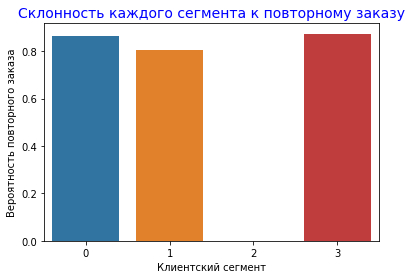

In [55]:
sns.barplot(data=df.groupby('cluster_km').mean().reset_index(), x='cluster_km', y='repeat')
plt.xlabel('Клиентский сегмент')
plt.ylabel('Вероятность повторного заказа')
plt.title('Склонность каждого сегмента к повторному заказу', color = 'blue', fontsize=14)
plt.show()

Посмотрим на соотношение доли каждого кластера в общем объеме как пользователей, так и продаж

In [56]:
df.groupby('cluster_km')['customer_id'].nunique()

cluster_km
0    1882
1     259
2       1
3     244
Name: customer_id, dtype: int64

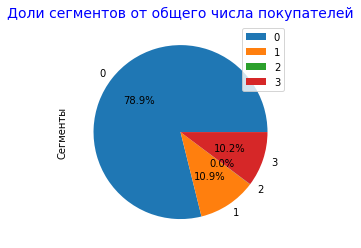

In [57]:
# доля пользователей каждого сегмента от общего числа покупателей
df.groupby('cluster_km').agg({'customer_id': 'nunique'}).plot.pie(y='customer_id', figsize=(4, 4), autopct='%1.1f%%')
plt.ylabel('Сегменты')
plt.title('Доли сегментов от общего числа покупателей', color = 'blue', fontsize=14)
plt.show()

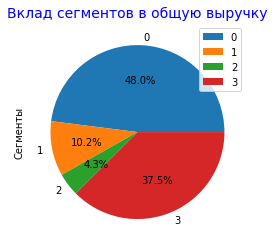

In [58]:
# вклад каждого сегмента в общую выручку
df.groupby('cluster_km').agg({'product_price': 'sum'}).plot.pie(y='product_price', figsize=(4, 4), autopct='%1.1f%%')
plt.ylabel('Сегменты')
plt.title('Вклад сегментов в общую выручку', color = 'blue', fontsize=14)
plt.show()

In [59]:
# определим категориальные столбцы
df_cat = df[['month_per', 'cat']]

In [60]:
# определим непрерывные столбцы
df_cont = df[['price', 'product_price', 'order_price', 'order_per_user', 'cluster_km']]

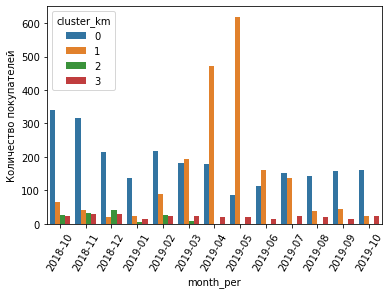

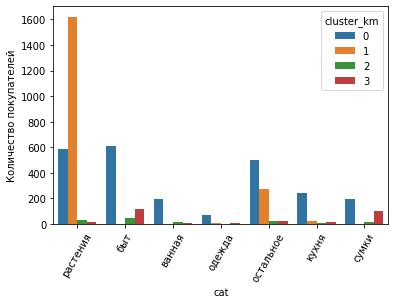

In [61]:
plt.subplots(figsize= (6,4))
for col in df_cat.columns:
    sns.countplot(data=df, x=col, hue='cluster_km')
    plt.xticks(rotation=60)
    plt.xlabel(col)
    plt.ylabel('Количество покупателей')
    #plt.grid()
    plt.show()


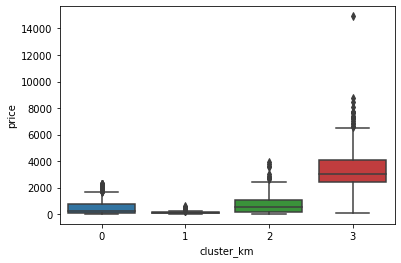

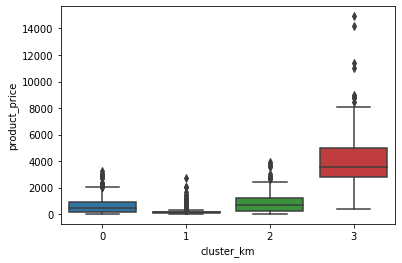

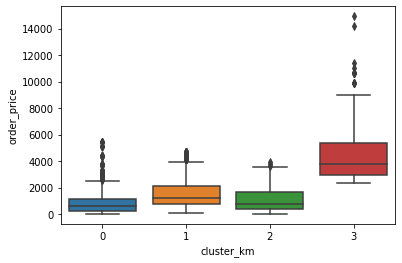

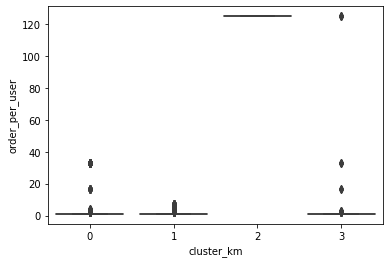

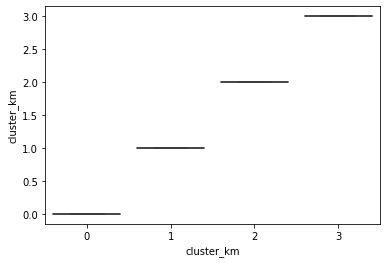

In [62]:
plt.subplots(figsize= (6,4))
for col in df_cont.columns:
    sns.boxplot(data=df_cont, x='cluster_km', y=col)
    plt.show()

In [63]:
df.groupby('cluster_km').mean().reset_index()

,cluster_km,order_id,quantity,price,month_dt,product_price,order_price,order_per_user,repeat
0,0,70532.674031,2.037516,500.871613,7.352230,603.849937,832.839516,1.734890,0.864110
1,1,14717.146050,1.413721,120.612266,5.175156,159.963098,1544.168919,1.360707,0.803015
2,2,69426.131387,1.868613,811.445255,8.649635,944.160584,1100.627737,125.000000,0.000000
3,3,69549.079710,2.648551,3285.028986,7.134058,4104.876812,4529.043478,3.985507,0.873188


Что имеем в итоге? Покупателей мы разбили на 4 сегмента

0 сегмент - самый многочисленный, но и самый низкочековый; его представители в основном закупаются бытовыми товарами, растениями и "остальной" категорией. На каждого пользователя приходится в среднем 1.7 заказа со средним чеком 833 рубля. Основная покупательская аквтиность приходится на октябрь-ноябрь

1 сегмент, судя по профилю - это дачники: они закупаются весной рассадой и растениями. Пусть количество заказов на одного покупателя у них меньше (в сравнении с 0 сегментом - 1.4 против 1.7), но средний чек в 2 раза выше - 1544 против 833.

2 сегмент - самый малочисленный) тут только один человек. Его мы смогли выделить потому, что его активность не подходит под описание остальных сегментов: у него 125 заказов со средним чеком 1100 за полгода активности с окбября по март. Что интересно, больше всего денег он тратит на бытовые товары и сумки.

3 сегмент отчасти похож на второй: также основными категориями являются бытовые товары и сумки. Но средний чек самый высокий-  4529; плюс количество заказов на одного покупателя самое высокое - около 4х

## Статистические различия в средних чеках между сегментами
<a id='6'></a>

Для удобства определим столбец среднего чека каждого сегмента в один фрейм

In [64]:
order_0 = df.query('cluster_km == 0').groupby('order_id').agg({'order_price': 'first'}).reset_index()['order_price']
order_1 = df.query('cluster_km == 1').groupby('order_id').agg({'order_price': 'first'}).reset_index()['order_price']
order_2 = df.query('cluster_km == 2').groupby('order_id').agg({'order_price': 'first'}).reset_index()['order_price']
order_3 = df.query('cluster_km == 3').groupby('order_id').agg({'order_price': 'first'}).reset_index()['order_price']

Теперь пропишем функцию, которая будет принимать на вход средние чеки двух сегментов и выдавать вердикт: отвергаем ли нулевую гипотезу о равенстве средних чеков или не можем ее отвергнуть

In [65]:
def check_hyp(x, y):
    alpha = 0.05
    results = st.ttest_ind(x, y)
    display('p-значение:', results.pvalue)
    if results.pvalue < alpha:
        display('Отвергаем нулевую гипотезу')
    else:
        display('Не получилось отвергнуть нулевую гипотезу') 

In [66]:
check_hyp(order_0, order_1)

'p-значение:'

2.077823346959338e-13

'Отвергаем нулевую гипотезу'

In [67]:
check_hyp(order_0, order_2)

'p-значение:'

5.472193249430829e-09

'Отвергаем нулевую гипотезу'

In [68]:
check_hyp(order_0, order_3)

'p-значение:'

0.0

'Отвергаем нулевую гипотезу'

In [69]:
check_hyp(order_1, order_2)

'p-значение:'

0.5253489970938218

'Не получилось отвергнуть нулевую гипотезу'

In [70]:
check_hyp(order_1, order_3)

'p-значение:'

1.0194965038585003e-101

'Отвергаем нулевую гипотезу'

In [71]:
check_hyp(order_2, order_3)

'p-значение:'

1.5040345393730684e-49

'Отвергаем нулевую гипотезу'

Итак, только при сравнении чеков 1 и 2 сегмента у нас не получилось отвергнуть нулевую гипотезу о равенстве средних чеков. Полученное значение p-value говорит о том, что хотя средний чек данных сегментов и неодинаков, с вероятностью в 52% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками. В остальных случаях статразница существенна

## Выводы
<a id='7'></a>

Еще на этапе предобработки мы заметили, что есть проблема с дубликатами: зачастую под одним номером заказа находились идентичные операции. Их мы отсекли для анализа, но нашим технарям обязательно дадим знать, чтобы в дальнейшем такое не повторялось

На этапе EDA мы заметили аномальные значения: как в чеке заказа, так и в количестве позиций в одном чеке. Их мы отсекли, но рекомендуем коллегам изучить отсеченных покупателей: возможно, это оптовики или перекупы. Стоит провести с ними переговоры по предоставлению индивидуальных условий при совершении регулярных подобных заказов

Самые прибыльные для нас месяцы - октябрь, ноябрь и декабрь 2018 года. В 2019 - февраль и апрель

Если говорить о категориях товаров, то есть вполне ожидаемый спад в январе (во всех сферах), есть сезонный рост закупок растений весной + предновогодний всплеск продаж

Самые продаваемые категории - товары бытового пользования, сумки и растения